# Deep Sets
Deep neural network trained on *permutation invariant* set-input data. We use encoder-decoder architecture inspired by 
https://proceedings.neurips.cc/paper_files/paper/2017/file/f22e4747da1aa27e363d86d40ff442fe-Paper.pdf

In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.utils import plot_model, to_categorical
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras.layers as L
import keras.backend as K
from keras_tuner import HyperParameters, RandomSearch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
%load_ext blackcellmagic
NUM_CLASSES = 20 # to_categorical maps to 0,...,NUM_CLASSES-1
MIN_VERTICES, MAX_VERTICES = 4, 14
input_shape = (3, MAX_VERTICES)

# Data
df = pd.read_csv("../data/Pic4319.csv", converters={"matrix":lambda s: np.array(literal_eval(s))}, header=None, names=["matrix", "pic"])
df["pad"] = df["matrix"].apply(lambda mat: np.pad(mat, ((0, 0), (0, MAX_VERTICES - mat.shape[1]))))
X, y = df["pad"], df["pic"]
X, y = np.stack(X), to_categorical(y, num_classes=NUM_CLASSES)
X = np.transpose(X, axes=[0,2,1])

2023-06-12 22:02:26.594064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [177]:
UNITS = [0, 8, 16, 32, 64]
LR = [1e-3, 5e-2, 1e-2]
DROPOUT = [0.0, 0.1, 0.2]


class PlotLearning(keras.callbacks.Callback):
    """Callback to plot the learning curves of the model during training."""

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if "val" not in x]
        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if logs["val_" + metric]:
                axs[i].plot(
                    range(1, epoch + 2),
                    self.metrics["val_" + metric],
                    label="val_" + metric,
                )
            axs[i].legend()
            axs[i].grid()
        plt.tight_layout()
        plt.show()


def width_acc(y_true, y_pred, width=1):
    diff = K.abs(K.argmax(y_pred, axis=-1) - K.argmax(y_true, axis=-1))
    res = tf.math.count_nonzero(K.less_equal(diff, width))
    return int(res) / int(tf.shape(y_pred)[0])


def plot_confusion(model, X_test, y_test):
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(model.predict(X_test), axis=1)
    conf_mat = confusion_matrix(y_true, y_pred, labels=range(1, NUM_CLASSES))
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=range(1, NUM_CLASSES))
    fig, ax = plt.subplots(figsize=(10,10)) 
    disp.plot(ax=ax, colorbar=False)
    plt.show()
    
# PointNet

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=1e-3):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

def tnet(hp, inputs, num_features, name=""):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    orth_reg = OrthogonalRegularizer(num_features)
    x = inputs
    
    for i in range(hp.Int(name+"conv", 1, 5)):
        filters = hp.Choice(name+f"filters_{i}", values=UNITS)
        x = L.Conv1D(filters, kernel_size=1, padding="valid", activation="relu")(x) if filters else x
        
    x = L.Dropout(hp.Choice(name+"conv_dropout", values=DROPOUT))(x)
        
    x = L.GlobalMaxPooling1D()(x)
    
    for i in range(hp.Int(name+"dense", 1, 5)):
        units = hp.Choice(f"units{i}", values=UNITS)
        x = L.Dense(units, activation="relu")(x)
        
    x = L.Dropout(hp.Choice(name+"dense_dropout", values=DROPOUT))(x)
        
    x = L.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=orth_reg,
    )(x)
    feat_T = L.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return L.Dot(axes=(2, 1))([inputs, feat_T])

def mlp(x, units_list=[], dense=False):
        # Encoder: MLP 
        for units in units_list:
            if dense:
                x = L.Dense(units, activation="relu")(x)
            else:
                x = L.Conv1D(units, kernel_size=1, activation="relu")(x)
        return x
    
def deepset_model(hp):
    lr = hp.Choice("lr", values=LR)
    decay = 1e-4
    optimizer = Adam(learning_rate=lr, decay=decay)
    metrics = ["accuracy", width_acc]
    
    inputs = L.Input(shape=(MAX_VERTICES, 3))
    x = L.Masking(mask_value=0, input_shape=(MAX_VERTICES, 3))(inputs)
    
    # Input Alignment
    x = tnet(hp, x, 3, name="input_tnet")
    
    # Encoder
    filters = hp.Choice("encoder", values=UNITS)
    x = L.Conv1D(filters, kernel_size=1, activation="relu", name="encoder")(x) if filters else x
    
    # Feature Alignment
    x = tnet(hp, x, x.shape[-1], name="feature_tnet")
    
    # Pooling
    x_avg = L.GlobalAveragePooling1D(data_format="channels_last", name="avg")(x)
    x_max = L.GlobalMaxPooling1D(data_format="channels_last", name="max")(x)
    x = L.Concatenate(name="pooling", axis=1)([x_avg, x_max])
    
    # Decoder
    units = hp.Choice("decoder", values=UNITS)
    x = L.Dense(units, activation="relu", name="decoder")(x) if units else x
    
    # Classifier
    # x = L.Flatten()(x)
    outputs = L.Dense(NUM_CLASSES, activation="softmax")(x)

    # Model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics)
    print(model.summary())
    return model

def train_model(model, data, batch_size=32, epochs=500):
    X_train, X_test, y_train, y_test = data
    callbacks_list = [
        PlotLearning(),
        EarlyStopping(monitor="val_loss", patience=100, verbose=1),
    ]
    hist = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        shuffle=True,
        callbacks=callbacks_list,
    )

    return model, hist.history

# plot_model(model, show_shapes=True, show_layer_names=False)
# plot_confusion(model, X_test, y_test)

In [172]:
tuner = RandomSearch(
    hypermodel=deepset_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="hp"
)
tuner.search(X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=32,
        epochs=300,
        verbose=1,
        shuffle=True,
        callbacks=[EarlyStopping(monitor="val_loss", patience=20, verbose=1)])
best_hp = tuner.get_best_hyperparameters()[0]

Trial 10 Complete [00h 00m 45s]
val_accuracy: 0.4683642089366913

Best val_accuracy So Far: 0.5632715821266174
Total elapsed time: 00h 22m 44s
INFO:tensorflow:Oracle triggered exit


In [173]:
tuner.results_summary()

Results summary
Results in hp/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
lr: 0.01
input_tnetconv: 2
input_tnetfilters_0: 8
input_tnetconv_dropout: 0.1
input_tnetdense: 4
units0: 32
input_tnetdense_dropout: 0.2
encoder: 64
feature_tnetconv: 3
feature_tnetfilters_0: 16
feature_tnetconv_dropout: 0.1
feature_tnetdense: 2
feature_tnetdense_dropout: 0.1
decoder: 8
input_tnetfilters_1: 32
feature_tnetfilters_1: 0
feature_tnetfilters_2: 32
units1: 32
input_tnetfilters_2: 16
units2: 64
units3: 16
input_tnetfilters_3: 0
input_tnetfilters_4: 32
units4: 32
feature_tnetfilters_3: 64
Score: 0.5632715821266174

Trial 08 summary
Hyperparameters:
lr: 0.001
input_tnetconv: 2
input_tnetfilters_0: 0
input_tnetconv_dropout: 0.0
input_tnetdense: 4
units0: 64
input_tnetdense_dropout: 0.0
encoder: 8
feature_tnetconv: 5
feature_tnetfilters_0: 8
feature_tnetconv_dropout: 0.1
feature_tnetdense: 1
feature_tnetdense_dropout: 0.1
decode

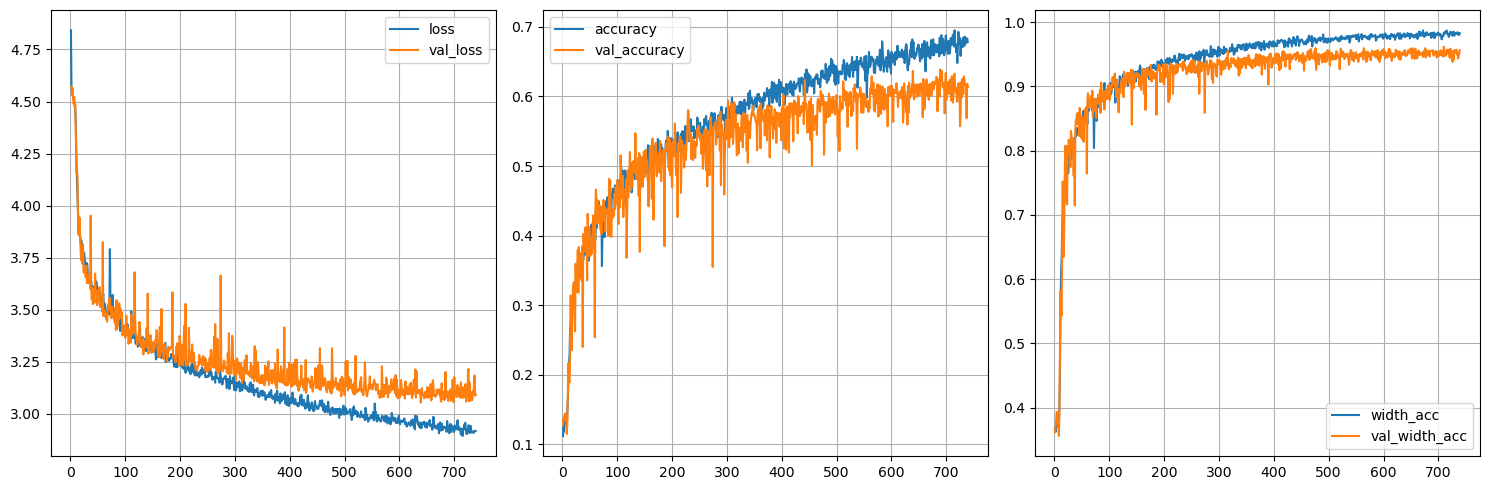

95/95 [==============================] - 4s 43ms/step - loss: 2.9183 - accuracy: 0.6781 - width_acc: 0.9829 - val_loss: 3.0918 - val_accuracy: 0.6134 - val_width_acc: 0.9566
Epoch 739: early stopping


In [175]:
data = X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=None)
# hp = tuner.get_best_hyperparameters(10)[0]
model = deepset_model(best_hp)
model, history = train_model(model, data, batch_size=32, epochs=1000)